**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.

Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.

* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
from skimage.feature import hog
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, 
                     feature_vec=True):
    return hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
        cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec,
        block_norm="L2-Hys")

In [2]:
import glob

vehicles_images = glob.glob("./vehicles/*/*.png")
print("Number of Vehicles Images: ", len(vehicles_images))
non_vehicles_images = glob.glob("./non-vehicles/*/*.png")
print("Number of Non-Vehicles Images: ", len(non_vehicles_images))


Number of Vehicles Images:  8792
Number of Non-Vehicles Images:  8968


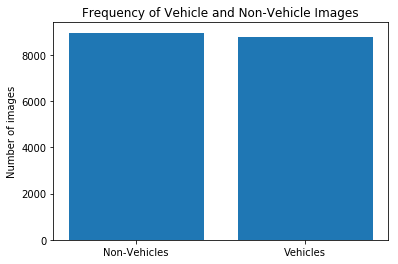

In [4]:
import matplotlib.pyplot as plt

x_values = ["Vehicles", "Non-Vehicles"]
y_values = [len(vehicles_images), len(non_vehicles_images)]
plt.bar(x_values, y_values)
plt.ylabel("Number of images")
plt.title("Frequency of Vehicle and Non-Vehicle Images")
plt.show()

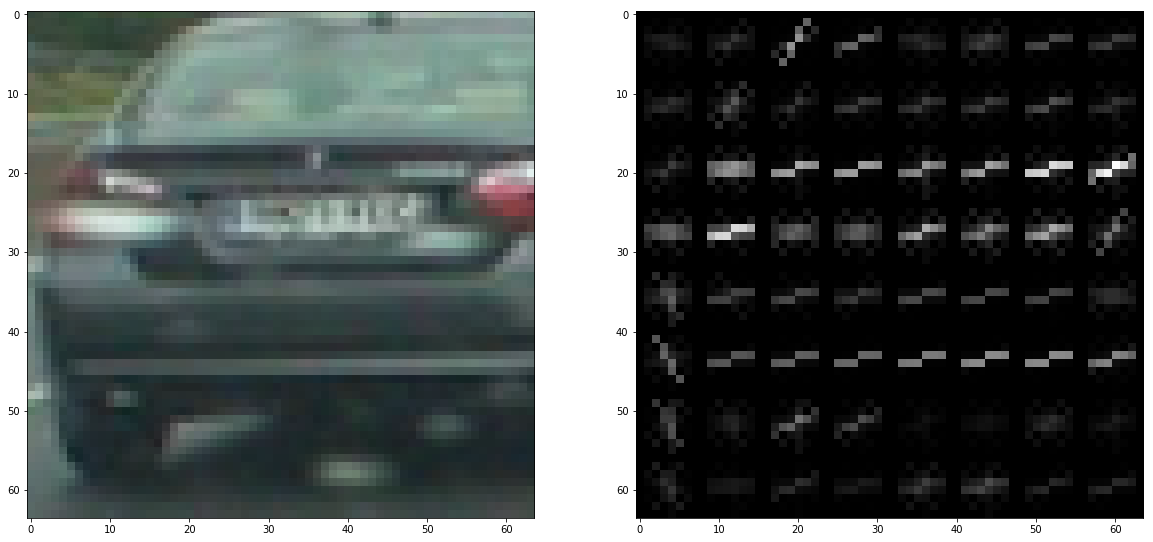

In [5]:
import matplotlib.image as mpimg
import numpy as np
import cv2

# Random car image
carImage = mpimg.imread(vehicles_images[np.random.randint(0, len(vehicles_images))])
features, hog_image = get_hog_features(cv2.cvtColor(carImage, cv2.COLOR_RGB2GRAY), orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=True)

f, (a1, a2) = plt.subplots(1,2,figsize=(20,10))
a1.imshow(carImage)
a2.imshow(hog_image, cmap='gray')

In [6]:
def extract_features(images):
    features = []
    for img in images:
        image = mpimg.imread(img)
        feature = get_hog_features(cv2.cvtColor(carImage, cv2.COLOR_RGB2GRAY), orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=False, feature_vec=True)
        features.append(feature)
    return features


In [7]:
car_features = extract_features(vehicles_images)

In [8]:
non_car_features = extract_features(non_vehicles_images)

In [9]:
X = np.vstack((car_features, non_car_features)).astype(np.float64)
print(X.shape)

(17760, 1764)


In [10]:
car_labels = np.repeat(1, len(car_features))
non_car_labels = np.repeat(0, len(non_car_features))
y = np.concatenate((car_labels, non_car_labels))
print(y.shape)

(17760,)


In [11]:
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler().fit(X)
X = X_scaler.transform(X)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
all_images = vehicles_images + non_vehicles_images
all_images, X, y = shuffle(all_images, X, y, random_state=24)
Images_train, Images_test, X_train, X_test, y_train, y_test = train_test_split(all_images,X,y,test_size=0.2,random_state=24)

In [13]:
print(Images_train[10:20])
print(y_train[10:20])

['./vehicles\\GTI_MiddleClose\\image0447.png', './vehicles\\GTI_Right\\image0956.png', './vehicles\\KITTI_extracted\\4966.png', './vehicles\\GTI_Far\\image0366.png', './non-vehicles\\GTI\\image1983.png', './vehicles\\KITTI_extracted\\4806.png', './vehicles\\KITTI_extracted\\3064.png', './non-vehicles\\GTI\\image2411.png', './vehicles\\KITTI_extracted\\1049.png', './vehicles\\KITTI_extracted\\3880.png']
[1 1 1 1 0 1 1 0 1 1]


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
#parameters = {'C':ra}
svr = SVC(kernel='linear', C=5)
#clf = GridSearchCV(svr, parameters)
clf.fit(X_train,y_train)
y_predicted = clf.predict(X_test)
print("Best Parameters:", clf.best_params_)


In [ ]:
print("Accuracy Score: ", accuracy_score(y_test, y_predicted))

100
100
200


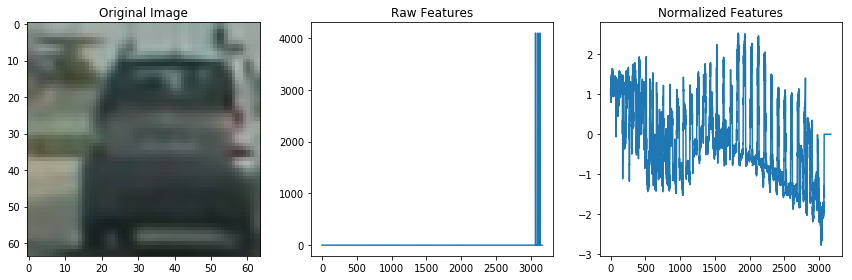

In [35]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
import glob

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

###### TODO ###########
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    for img in imgs:
        # Read in each one by one
        image = mpimg.imread(img)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    return features

cars = vehicles_images[:100]
notcars = non_vehicles_images[:100]
        
car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))

if len(vehicles_images) > 0:
    # Create an array stack of feature vectors
    print(len(car_features))
    print(len(notcar_features))
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                    
    print(len(X))
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')